#### Load required libraries

In [12]:
import numpy as np
import logging
import pickle
# required libraries for Reconstructor matrix computation or MPC
from scipy import sparse

import os.path
from os import path

from pathlib import Path
import dos


# sim_folder = 'dos/SHWFS'
sim_folder = 'dos/SHWFS_ES'

#### Compute reconstructor from interacion matrix

In [13]:
# * * * Flag to control if reconstructor matrix is updated * * *
updateReconst = True

if (not path.exists(sim_folder+'/ReconstructorM.pickle')) or (updateReconst):
    # Open reconstructor pickle data file
    if(sim_folder == 'dos/SHWFS_ES'):
        file = open('/Users/rromano/Workspace/GMT_AcO/Reconstructor/AcO_SHWFS_ES_Rec.pickle', 'rb')
    elif(sim_folder == 'dos/SHWFS'):
        file = open('/Users/rromano/Workspace/GMT_AcO/Reconstructor/AcO_SHWFS_Rec.pickle', 'rb')

    RecDt = pickle.load(file)

    if(sparse.issparse(RecDt['RecM'])):
        RecM = RecDt['RecM'].toarray()
    else:
        RecM = RecDt['RecM']
        
    Msimceo = np.zeros_like(RecM)    
    n_bm = (M.shape[0] - 84)//7

    for k in range (7):
        row_sel = np.hstack([np.arange(6)+6*k,
                             np.arange(42,48)+6*k,
                             np.arange(84,84+n_bm)+n_bm*k])
        Msimceo[len(row_sel)*k:len(row_sel)*(k+1),:] = RecM[row_sel,:]
    
    # Generate SIMCEO reconstructor pickle file
    dos.tools.linear_estimator_2_dos(Msimceo,sim_folder+'/ReconstructorM', B_or_D='D')
    print('SH-WFS reconstructor matrix pickle file is updated!')

SH-WFS reconstructor matrix pickle file is updated!


#### Set initial M1/M2 states and generate respective yaml files

In [ ]:
# Python code to set simulation states...
from ruamel import yaml
from ruamel.yaml import YAML

# * * * Flag to control if simulation initial state is updated * * *
updateState0 = False

asec2rad = 4.84814e-6
n_bm = 46
k_states = 0
x0 = np.zeros(42+42+7*n_bm)

if (not path.exists(sim_folder+'/M1.yaml')) or (updateState0):
    # M1 random initial values
    x0_M1_Txy = k_states*75.0e-6*np.random.randn(7,2)
    x0_M1_Tz = k_states*np.hstack([160.0e-6*np.random.randn(6),0]).reshape((7, 1))
    x0_M1_Rxy = k_states*0.38*asec2rad*np.random.randn(7,2)
    x0_M1_Rz = k_states*40*asec2rad*np.random.randn(7,1)
    x0_BM = k_states*4e-6*np.random.randn(7, n_bm)

    
    M1dict = {
        'mirror' : 'M1',
        'mirror_args': {'mirror_modes': 'bending modes', 
                        'N_MODE': n_bm},
        'state': {'Txyz': np.hstack([x0_M1_Txy, x0_M1_Tz]).tolist(),
                  'Rxyz': np.hstack([x0_M1_Rxy, x0_M1_Rz]).tolist(),
                  'modes': x0_BM.tolist() }
    }
    # Dump M1 inital state
    y = YAML()
    y.default_flow_style = None
    with open(Path(sim_folder)/'M1.yaml','w') as f:
        y.dump(M1dict, f)

if (not path.exists(sim_folder+'/M2.yaml')) or (updateState0):        
    # M2 random initial values
    x0_M2_Txy = k_states*75.0e-6*np.random.randn(7,2)
    x0_M2_Tz = k_states*170.0e-6*np.random.randn(7,1)
    x0_M2_Rxy = k_states*3.0*asec2rad*np.random.randn(7,2)
    x0_M2_Rz = k_states*330*asec2rad*np.random.randn(7,1)

    M2dict = {
        'mirror' : 'M2',
        'mirror_args': {},
        'state': {'Txyz': np.hstack([x0_M2_Txy, x0_M2_Tz]).tolist(),
                  'Rxyz': np.hstack([x0_M2_Rxy, x0_M2_Rz]).tolist()}
    }
    # Dump M2 inital state
    with open(Path(sim_folder)/'M2.yaml','w') as f:
        y.dump(M2dict, f)


#### Instantiate DOS

In [14]:
sim = dos.DOS(sim_folder,verbose=logging.INFO,show_timing=2)

INFO:DOS:Reading config from dos/SHWFS_ES/dos.yaml
INFO:DOS:New driver: M1
INFO:M1:New input: Txyz
INFO:M1:New input: Rxyz
INFO:M1:New input: modes
INFO:M1:No inputs!
INFO:DOS:New driver: M2
INFO:M2:New input: Txyz
INFO:M2:New input: Rxyz
INFO:M2:No inputs!
INFO:DOS:New driver: wfs48
INFO:wfs48:No inputs!
INFO:wfs48:New output: data
INFO:wfs48:New output: M12_RBM
INFO:wfs48:Output logged in!
INFO:DOS:New driver: M1_ES
INFO:M1_ES:No inputs!
INFO:M1_ES:New output: deltas
INFO:M1_ES:Output logged in!
INFO:DOS:New driver: ReconstructorM
INFO:ReconstructorM:New input: SH-WFS
INFO:ReconstructorM:New input: edge sensors
INFO:ReconstructorM:New output: x_hat
INFO:ReconstructorM:Output logged in!
INFO:DOS:New driver: AcO_controller
INFO:AcO_controller:New input: x_hat
INFO:AcO_controller:New output: M1 Txyz
INFO:AcO_controller:Output logged in!
INFO:AcO_controller:New output: M1 Rxyz
INFO:AcO_controller:Output logged in!
INFO:AcO_controller:New output: M2 Txyz
INFO:AcO_controller:Output logged 

SIMCEO server received: Acknowledging connection from SIMCEO client!


INFO:DOS:Simulation setup for a duration of 50s @ 1Hz (50 steps)!


In [65]:
sim.push()

INFO:DOS:Pushing configuration to server
INFO:M1:GMT
INFO:M2:GMT
INFO:wfs48:OP0
INFO:science:OP1


In [66]:
sim.init()

INFO:DOS:Initializing
INFO:M1:None
INFO:M2:None
INFO:wfs48:None
INFO:science:None


In [67]:
sim.terminate()

INFO:DOS:Terminating
INFO:M1:GMT deleted!
INFO:M2:GMT deleted!
INFO:wfs48:OpticalPath deleted!
INFO:science:OpticalPath deleted!


In [15]:
# Start simulation
sim.start()

INFO:DOS:Pushing configuration to server
INFO:M1:GMT
INFO:M2:GMT
INFO:wfs48:OP0
INFO:M1_ES:EdgeSensors
INFO:science:OP1
INFO:DOS:Initializing
INFO:M1:None
INFO:M2:None
INFO:wfs48:None
INFO:M1_ES:None
INFO:science:None
INFO:DOS:Running
INFO:DOS:Terminating
INFO:M1:GMT deleted!
INFO:M2:GMT deleted!
INFO:wfs48:OpticalPath deleted!
INFO:M1_ES:EdgeSensors deleted!
INFO:science:OpticalPath deleted!


Elapsed time: 27.953325986862183


In [16]:
sim.logs.entries.keys(), sim.logs

(dict_keys(['wfs48', 'M1_ES', 'ReconstructorM', 'AcO_controller', 'science']),
 The 'logs' has 12 entries:
  * wfs48
    1. M12_RBM: (406,)x50
  * M1_ES
    1. deltas: (48,)x50
  * ReconstructorM
    1. x_hat: (406,)x50
  * AcO_controller
    1. M1 Txyz: (7, 3)x50
    2. M1 Rxyz: (7, 3)x50
    3. M2 Txyz: (7, 3)x50
    4. M2 Rxyz: (7, 3)x50
    5. M1 BM: (7, 46)x50
  * science
    1. wfe_rms: (1,)x50
    2. tiptilt: (2,)x50
    3. segment_piston: (7,)x50
    4. segment_tiptilt: (14,)x50)

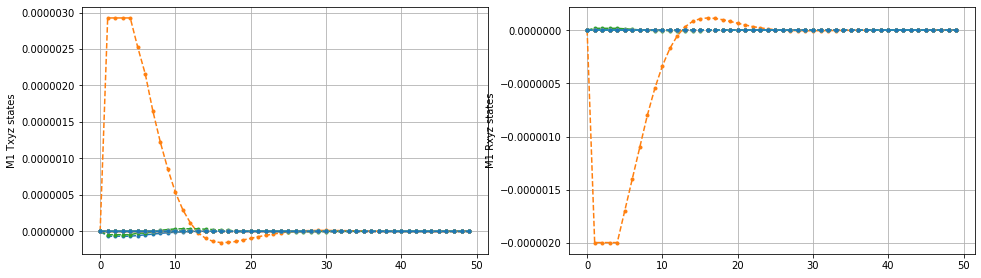

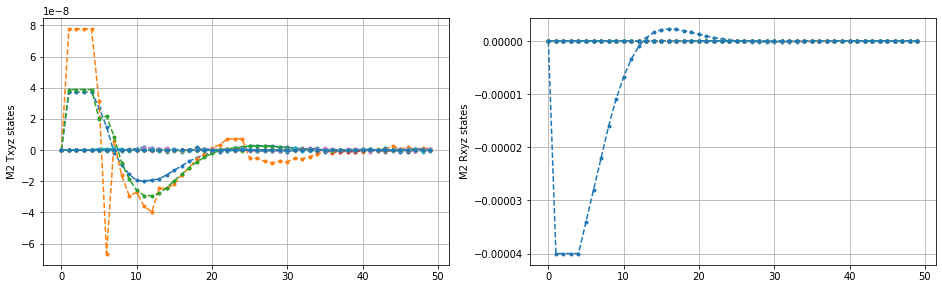

Text(0, 0.5, 'M1 BM states')

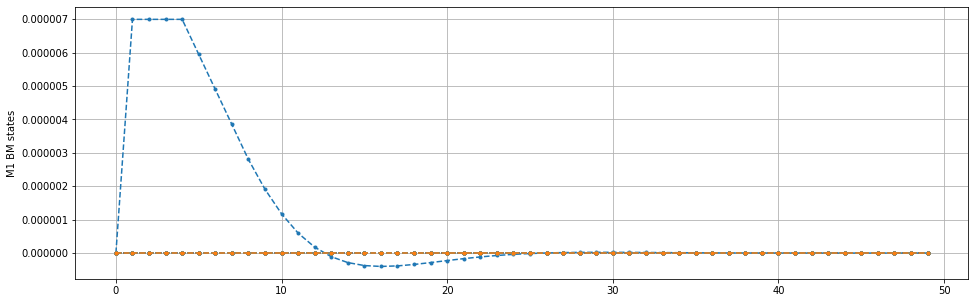

In [17]:
X = sim.logs.entries['ReconstructorM']['x_hat'].timeSeries

# Indices for M1 states
indX = np.reshape(np.arange(X[1].shape[1]), [7, 6 + 6 + 46])
i1,i2,i3,i4,i5 = np.split(indX,[3, 6, 9, 12],axis=1)

#auxTxy = np.array([0,1, 6,7, 12,13, 18,19, 24,25, 30,31, 36,37])
#auxTz = np.array([2, 8, 14, 20, 26, 32, 38])
#auxRxy = auxTxy + 3
#auxRz = auxTz + 3

xM1_Txyz = X[1][:,np.reshape(i1,[21])]
xM1_Rxyz = X[1][:,np.reshape(i2,[21])]
xM2_Txyz = X[1][:,np.reshape(i3,[21])]
xM2_Rxyz = X[1][:,np.reshape(i4,[21])]
xM1_BM = X[1][:,np.reshape(i5,[46*7])]

# Plot mirror states
import matplotlib.pyplot as plt

plt.figure(figsize=(16,10))
plt.subplot(221)
plt.plot(X[0],xM1_Txyz,'.--')
plt.grid(True)
plt.ylabel('M1 Txyz states')
    
plt.subplot(222)
plt.plot(X[0],xM1_Rxyz,'.--')
plt.grid(True)
plt.ylabel('M1 Rxyz states')    

plt.figure(figsize=(16,10))
plt.subplot(223)
plt.plot(X[0],xM2_Txyz,'.--')
plt.grid(True)
plt.ylabel('M2 Txyz states')
    
plt.subplot(224)
plt.plot(X[0],xM2_Rxyz,'.--')
plt.grid(True)
plt.ylabel('M2 Rxyz states')   
plt.show()

plt.figure(figsize=(16,5))
plt.plot(X[0],xM1_BM,'.--')
plt.grid(True)
plt.ylabel('M1 BM states')

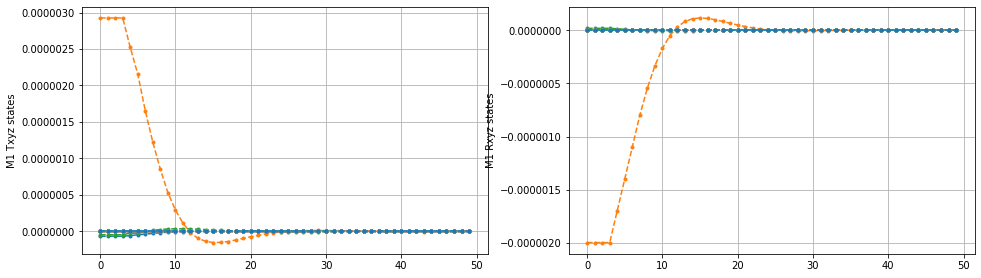

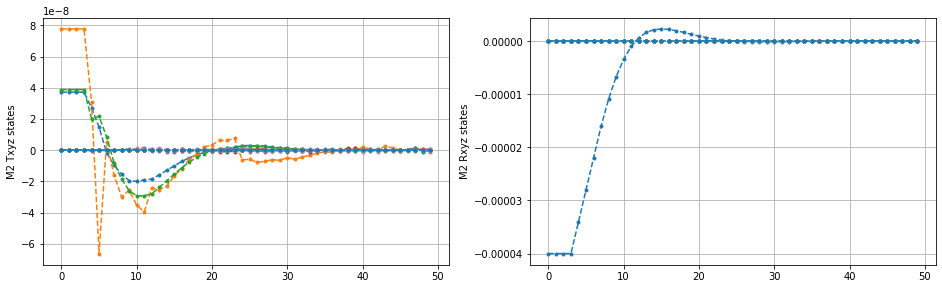

Text(0, 0.5, 'M1 BM states')

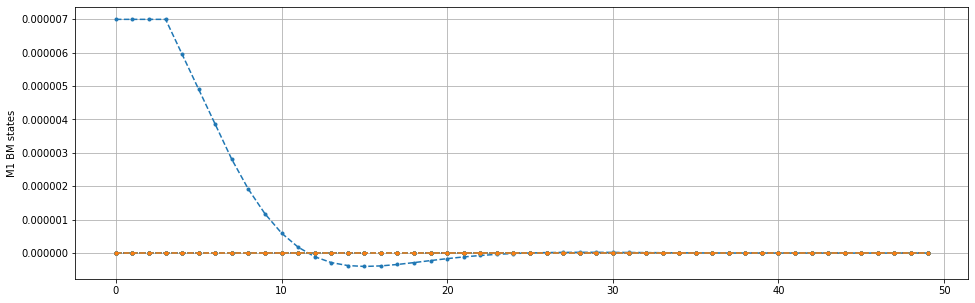

In [10]:
Z = sim.logs.entries['wfs48']['M12_RBM'].timeSeries

xM1_Txyz = Z[1][:,np.reshape(i1,[21])]
xM1_Rxyz = Z[1][:,np.reshape(i2,[21])]
xM2_Txyz = Z[1][:,np.reshape(i3,[21])]
xM2_Rxyz = Z[1][:,np.reshape(i4,[21])]
xM1_BM = Z[1][:,np.reshape(i5,[46*7])]

# Plot mirror states
import matplotlib.pyplot as plt

plt.figure(figsize=(16,10))
plt.subplot(221)
plt.plot(X[0],xM1_Txyz,'.--')
plt.grid(True)
plt.ylabel('M1 Txyz states')
    
plt.subplot(222)
plt.plot(X[0],xM1_Rxyz,'.--')
plt.grid(True)
plt.ylabel('M1 Rxyz states')    

plt.figure(figsize=(16,10))
plt.subplot(223)
plt.plot(X[0],xM2_Txyz,'.--')
plt.grid(True)
plt.ylabel('M2 Txyz states')
    
plt.subplot(224)
plt.plot(X[0],xM2_Rxyz,'.--')
plt.grid(True)
plt.ylabel('M2 Rxyz states')   
plt.show()

plt.figure(figsize=(16,5))
plt.plot(X[0],xM1_BM,'.--')
plt.grid(True)
plt.ylabel('M1 BM states')

[[[ 1.01136480e-08  2.02272959e-08  3.03409439e-08  4.04545918e-08]
  [-4.38901574e-07 -8.77803149e-07 -1.31670472e-06 -1.75560630e-06]
  [ 7.00887707e-09  1.40177541e-08  2.10266312e-08  2.80355083e-08]]

 [[ 2.77085480e-19  5.54170959e-19  8.31256439e-19  1.10834192e-18]
  [ 3.18321304e-19  6.36642607e-19  9.54963911e-19  1.27328521e-18]
  [-6.73347071e-19 -1.34669414e-18 -2.02004121e-18 -2.69338828e-18]]

 [[ 7.32135769e-19  1.46427154e-18  2.19640731e-18  2.92854308e-18]
  [ 6.60446343e-18  1.32089269e-17  1.98133903e-17  2.64178537e-17]
  [-1.74055601e-19 -3.48111202e-19 -5.22166803e-19 -6.96222404e-19]]]


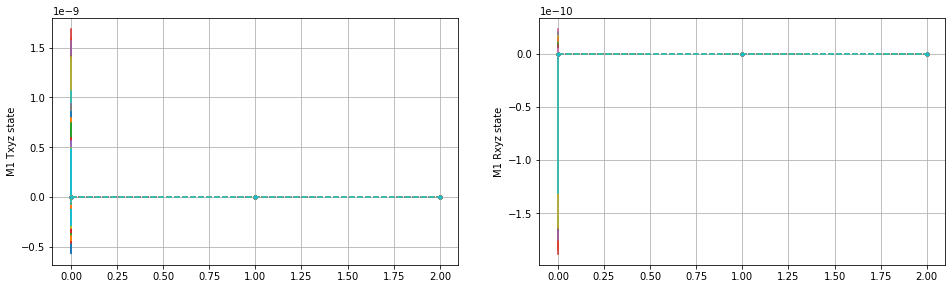

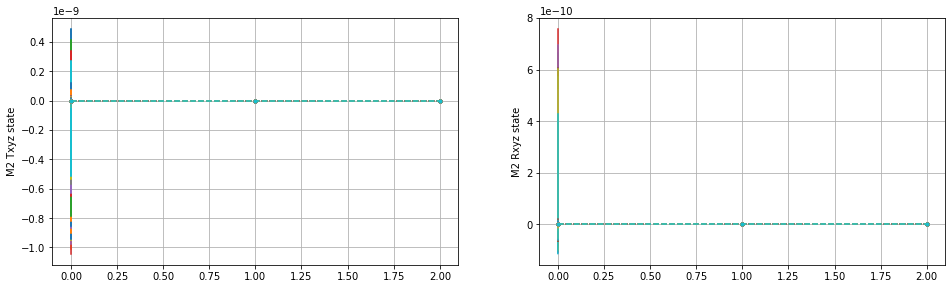

In [11]:
M1Txyz = sim.logs.entries['AcO_controller']['M1 Txyz'].timeSeries
M1Rxyz = sim.logs.entries['AcO_controller']['M1 Rxyz'].timeSeries
M1BM = sim.logs.entries['AcO_controller']['M1 BM'].timeSeries
M2Txyz = sim.logs.entries['AcO_controller']['M2 Txyz'].timeSeries
M2Rxyz = sim.logs.entries['AcO_controller']['M2 Rxyz'].timeSeries

print(M1Txyz[1][:3,:,3:7])

# Plot mirror states
import matplotlib.pyplot as plt

plt.figure(figsize=(16,10))
plt.subplot(221)
plt.plot(*M1Txyz[1],'.--')
plt.grid(True)
plt.ylabel('M1 Txyz state')
    
plt.subplot(222)
plt.plot(*M1Rxyz[1],'.--')
plt.grid(True)
plt.ylabel('M1 Rxyz state')    

plt.figure(figsize=(16,10))
plt.subplot(223)
plt.plot(*M2Txyz[1],'.--')
plt.grid(True)
plt.ylabel('M2 Txyz state')
    
plt.subplot(224)
plt.plot(*M2Rxyz[1],'.--')
plt.grid(True)
plt.ylabel('M2 Rxyz state')   
plt.show()


In [113]:
temp = np.arange(7*58)
#temp = X[1][2,:]
x = np.reshape(temp,[7,58])
x1,x2,x3,x4,x5 = np.split(x,[3, 6, 9, 12],axis=1)
print('M1Txyz\n',x1,'\nM1Rxyz\n',x2,'\nM2Txyz\n',x3,'\nM2Rxyz\n',x4,'\n',x5)

M1Txyz
 [[  0   1   2]
 [ 58  59  60]
 [116 117 118]
 [174 175 176]
 [232 233 234]
 [290 291 292]
 [348 349 350]] 
M1Rxyz
 [[  3   4   5]
 [ 61  62  63]
 [119 120 121]
 [177 178 179]
 [235 236 237]
 [293 294 295]
 [351 352 353]] 
M2Txyz
 [[  6   7   8]
 [ 64  65  66]
 [122 123 124]
 [180 181 182]
 [238 239 240]
 [296 297 298]
 [354 355 356]] 
M2Rxyz
 [[  9  10  11]
 [ 67  68  69]
 [125 126 127]
 [183 184 185]
 [241 242 243]
 [299 300 301]
 [357 358 359]] 
 [[ 12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29
   30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
   48  49  50  51  52  53  54  55  56  57]
 [ 70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87
   88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105
  106 107 108 109 110 111 112 113 114 115]
 [128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
  146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163
  164 165